In [13]:
import torch
import pickle
import numpy as np
from simulator_lstm import CustomEnv
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')




model_path = '../data/VesselSimulator/lstm_model_crop.pth'
scaler_path = '../data/VesselSimulator/scaler.pkl'
start_trip_path = '../data/VesselSimulator/start_trip.pkl'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
env = CustomEnv(model_path, start_trip_path, scaler_path = scaler_path, device = device)
with open(scaler_path, 'rb') as f:
        content = pickle.load(f)
        scaler = content['scaler']
print(env.reset())
state, reward, done, info = env.step()
print(env.step([0.5, 0.5, 0])) # SPEED, HEADING, MODE

tensor([0.4327, 0.4912, 1.0000, 0.5628, 0.7708, 0.1548, 0.0418, 0.9057, 0.1955,
        1.0000, 0.9951, 0.0000, 0.0014, 0.6085, 0.4888, 0.0133, 0.0000, 0.0705,
        0.2376, 0.4327, 0.0000, 0.0023])
(tensor([0.5000, 0.5000, 0.0000, 0.6656, 0.4293, 0.6951, 0.6861, 0.3377, 0.2548,
        1.0000, 0.7846, 0.0141, 0.0071, 0.6311, 0.5712, 0.1533, 0.6775, 0.3044,
        0.2741, 0.0868, 0.2105, 0.2116]), np.float32(-0.06332211), np.False_, {'prediction': array([0.27409962, 0.37106484, 0.21046066, 0.21156295, 0.251176  ,
       0.24273968, 0.30292982, 0.33571205, 0.27020016, 0.27198473,
       0.27856678, 0.29328912, 0.16610312, 0.26533356, 0.19899522,
       0.23953038, 0.22848769, 0.20312572], dtype=float32), 'state_org': {'SPEED': np.float32(1026.2926), 'HEADING': np.float32(179.95), 'MODE': np.float32(1.0), 'ENGINE_FLOWTEMPA': np.float32(53.39401), 'PITCH': np.float32(455.85275), 'POWER': np.float32(5877.555), 'STW': np.float32(19.029726), 'WIND_ANGLE': np.float32(121.5619), 'WIND_SPEED

In [14]:
test_path = '../data/VesselSimulator/data_test.pkl'
with open(test_path, 'rb') as f:
    content = pickle.load(f)
    X1_test_state = content['X1'][0] 
    X1_test_target = content['X1'][1]


# Select each trip, then go over each time step, and apply the step
X1_test_state_pred = np.zeros((5, 130, 24)) # 22 states + 1 done flag + 1 reward
X1_test_target_pred = np.zeros((5, 130, 6)) # SFC, SOG, LAT, LON, 'EAT', 'cf_SFC'
for i in range(len(X1_test_state)):
    current_trip = X1_test_state[i]
    env.reset(current_trip[0][:22]) # without the done flag
    for j in range(len(current_trip)):
        state, reward, done, info = env.step(current_trip[j][:3]) # SPEED, HEADING, MODE
        X1_test_state_pred[i][j] = np.concatenate([[info['state_org'][k] for k in info['state_org'].keys()], [done], [reward]])
        X1_test_target_pred[i][j] = np.array([info['output_org']['SFC'], info['output_org']['SOG'], info['output_org']['LAT'], info['output_org']['LON'], info['output_org']['EAT'], info['output_org']['cf_SFC']])
        if done:
            break


# remove the last column (done flag) from X1_test_state
X1_test_state = X1_test_state[:, :, :-1]
# concatenate X1_test_state and X1_test_target on last axis to do inverse_transform
X1_test = np.concatenate([X1_test_state, X1_test_target], axis=2)
# now inverse transform
X1_test_org = scaler.inverse_transform(X1_test.reshape(-1,  X1_test.shape[2]))
# reshape back to original shape
X1_test_org = X1_test_org.reshape(X1_test.shape[0], X1_test.shape[1], X1_test.shape[2])
# now compare the original and predicted values by plotting



X1_test_org = X1_test_org[:, :-25, :]
X1_test_target_pred = X1_test_target_pred[:, :-25, :]
X1_test_state_pred = X1_test_state_pred[:, :-25, :]





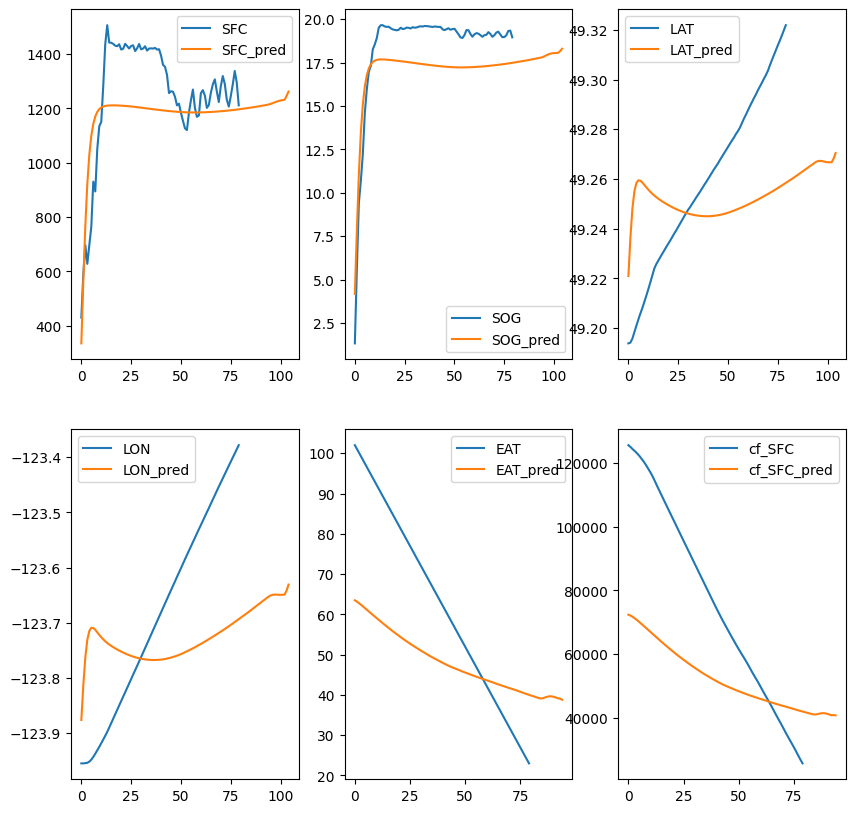

In [31]:
# select a trip 
id = 3
plt.figure(figsize=(10, 10))
# compare ouput values
ax = plt.subplot(2, 3, 1)
ax.plot(X1_test_org[id, :, 22], label='SFC')
ax.plot(X1_test_target_pred[id, :, 0], label='SFC_pred')  
ax.legend()
ax = plt.subplot(2, 3, 2)
ax.plot(X1_test_org[id, :, 23], label='SOG')
ax.plot(X1_test_target_pred[id, :, 1], label='SOG_pred')
ax.legend()
ax = plt.subplot(2, 3, 3)
ax.plot(X1_test_org[id, :, 24], label='LAT')
ax.plot(X1_test_target_pred[id, :, 2], label='LAT_pred')
ax.legend()
ax = plt.subplot(2, 3, 4)
ax.plot(X1_test_org[id, :, 25], label='LON')
ax.plot(X1_test_target_pred[id, :, 3], label='LON_pred')
ax.legend()
ax = plt.subplot(2, 3, 5)
ax.plot(X1_test_org[id, :, 26], label='EAT')
ax.plot(X1_test_target_pred[id, 10:, 4], label='EAT_pred')
ax.legend()
ax = plt.subplot(2, 3, 6)
ax.plot(X1_test_org[id, :, 27], label='cf_SFC')
ax.plot(X1_test_target_pred[id, 10:, 5], label='cf_SFC_pred')
ax.legend()
plt.show()

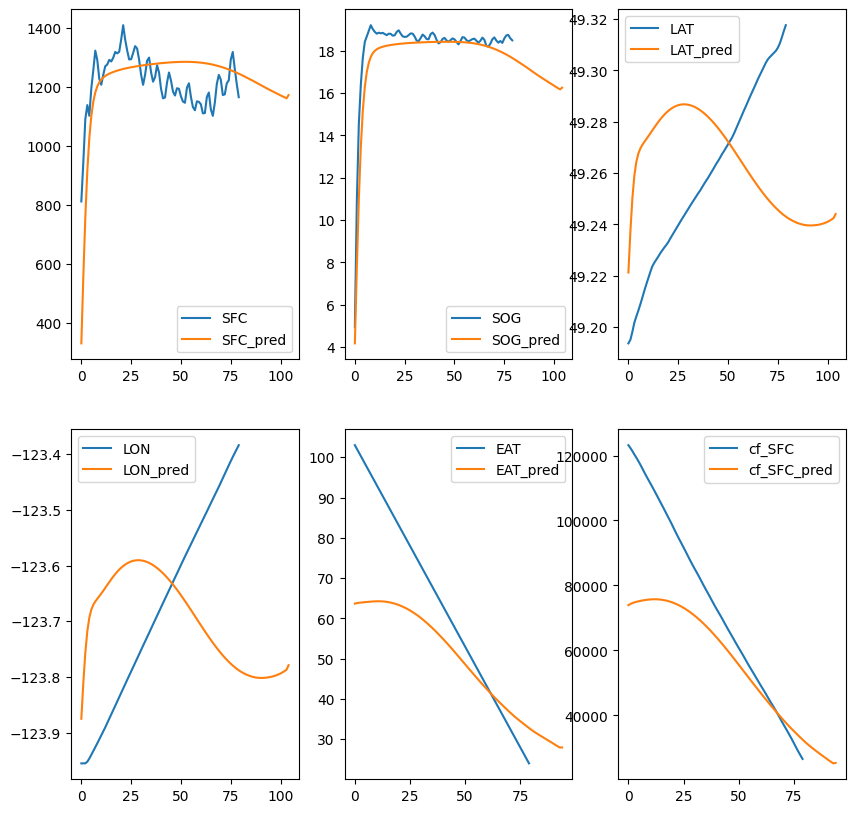

In [27]:
# select a trip 
id = 1
# create a large figure
plt.figure(figsize=(10, 10))
# compare ouput values
ax = plt.subplot(2, 3, 1)
ax.plot(X1_test_org[id, :, 22], label='SFC')
ax.plot(X1_test_target_pred[id, :, 0], label='SFC_pred')  
ax.legend()
ax = plt.subplot(2, 3, 2)
ax.plot(X1_test_org[id, :, 23], label='SOG')
ax.plot(X1_test_target_pred[id, :, 1], label='SOG_pred')
ax.legend()
ax = plt.subplot(2, 3, 3)
ax.plot(X1_test_org[id, :, 24], label='LAT')
ax.plot(X1_test_target_pred[id, :, 2], label='LAT_pred')
ax.legend()
ax = plt.subplot(2, 3, 4)
ax.plot(X1_test_org[id, :, 25], label='LON')
ax.plot(X1_test_target_pred[id, :, 3], label='LON_pred')
ax.legend()
ax = plt.subplot(2, 3, 5)
ax.plot(X1_test_org[id, :, 26], label='EAT')
ax.plot(X1_test_target_pred[id, 10:, 4], label='EAT_pred')
ax.legend()
ax = plt.subplot(2, 3, 6)
ax.plot(X1_test_org[id, :, 27], label='cf_SFC')
ax.plot(X1_test_target_pred[id, 10:, 5], label='cf_SFC_pred')
ax.legend()
plt.show()